# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

In [21]:
!g++ -o tp_openmp_part_1_pi_sequential part1/tp_openmp_part_1_pi_sequential.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_critical part1/tp_openmp_part_1_pi_impl_critical.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_reduce part1/tp_openmp_part_1_pi_impl_reduce.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_atomic part1/tp_openmp_part_1_pi_impl_atomic.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_n_reduction part1/tp_openmp_part_1_pi_impl_n_reduction.cpp -fopenmp -O3 -march=native


### Performance evaluation

In [22]:
import os
import subprocess
import pandas as pd

try:
    os.remove("stats.csv")
except OSError:
    pass

df = pd.DataFrame(columns=['version','nthread','num_steps','runtime'])
df.to_csv("stats_part1_seq.csv", index=False)

num_steps = [10000, 1000000, 10000000, 100000000]
nb_threads = [1, 2, 4, 8]
repeats = range(0,10)

for nsteps in num_steps:
    for nthread in nb_threads:
        for repeat in repeats:
            args = ("./tp_openmp_part_1_pi_sequential", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()
            
            args = ("./tp_openmp_part_1_pi_impl_critical", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            
            args = ("./tp_openmp_part_1_pi_impl_reduce", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_openmp_part_1_pi_impl_atomic", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()


            args = ("./tp_openmp_part_1_pi_impl_n_reduction", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()          



### Performance analysis

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings

In [ ]:

warnings.filterwarnings('ignore')

df = pd.read_csv('stats_part1.csv',header=0,names=['version','nthread','num_steps','runtime'],dtype={
                     'version': str,
                     'nthread': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {10000 : "blue", 1000000 : "red", 10000000 : "green", 100000000 : "black"}

for num_steps in df['num_steps'].drop_duplicates():
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "sequential"]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="solid",color=color_num_steps[num_steps], label=f'{num_steps} sequential')
    plt.yscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)
    
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "critical"]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dotted",color=color_num_steps[num_steps], label=f'{num_steps} critical')
    plt.yscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)

    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "atomic"]    
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle=(0, (3, 1, 1, 1, 1, 1)),color=color_num_steps[num_steps], label=f'{num_steps} atomic')
    plt.yscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)

    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "reduce")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dashed",color=color_num_steps[num_steps], label= f'{num_steps} reduce')
    plt.yscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)

    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "n_reduce")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dashdot",color=color_num_steps[num_steps], label=f'{num_steps} n_reduce')
    plt.yscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)
    
plt.xlabel('nb_thread')
plt.ylabel('runtime')
plt.legend(loc='lower right', bbox_to_anchor=(-0.2, 0))
plt.show()

fig = plt.figure()
ax1 = plt.subplot(321)
ax2 = plt.subplot(323)
ax3 = plt.subplot(324)
ax4 = plt.subplot(325)
ax5 = plt.subplot(326)

for num_steps in df['num_steps'].drop_duplicates():
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "sequential"]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    ax1.set_yscale('log')
    ax1.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="solid",color=color_num_steps[num_steps], label=f'{num_steps} sequential')
    ax1.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)
    ax1.set_title('SEQUENTIAL')
    ax1.set_xlabel("nb_thread")
    ax1.set_ylabel("runtime")

for num_steps in df['num_steps'].drop_duplicates():
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "critical"]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    ax2.set_yscale('log')
    ax2.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dotted",color=color_num_steps[num_steps], label=f'{num_steps} critical')
    ax2.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)
    ax2.set_title('CRITICAL')
    ax2.set_xlabel("nb_thread")
    ax2.set_ylabel("runtime")

for num_steps in df['num_steps'].drop_duplicates():
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "atomic"]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    ax3.set_yscale('log')
    ax3.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle=(0, (3, 1, 1, 1, 1, 1)),color=color_num_steps[num_steps], label=f'{num_steps} atomic')
    ax3.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)
    ax3.set_title('ATOMIC')
    ax3.set_ylabel("runtime")
    ax3.set_xlabel("nb_thread")

for num_steps in df['num_steps'].drop_duplicates():
    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "reduce")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    ax4.set_yscale('log')
    ax4.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dashed",color=color_num_steps[num_steps], label= f'{num_steps} reduce')
    ax4.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)
    ax4.set_title('REDUCE')
    ax4.set_xlabel("nb_thread")
    ax4.set_ylabel("runtime")

for num_steps in df['num_steps'].drop_duplicates():
    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "n_reduce")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    ax5.set_yscale('log')
    ax5.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dashdot",color=color_num_steps[num_steps], label=f'{num_steps} n_reduce')
    ax5.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)
    ax5.set_title('N_REDUCE')
    ax5.set_xlabel("nb_thread")
    ax5.set_ylabel("runtime")

plt.tight_layout()
plt.show()


In [ ]:
color_thread = {1 : "blue", 2 : "red", 4 : "green", 8 : "black"}

for thread in df['nthread'].drop_duplicates():
    df_plot = df[(df['nthread'] == int(thread))]
    df_plot = df_plot[df_plot['version'] == "sequential"]
    mean_stats = df_plot.groupby(['nthread','num_steps','version']).mean().reset_index()
    plt.plot(mean_stats['num_steps'], mean_stats['runtime'],linestyle="solid",color=color_thread[thread], label=f'{thread} thread sequential')
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(df_plot['num_steps'], df_plot['runtime'],color=color_thread[thread], label=None)
    
    df_plot = df[(df['nthread'] == int(thread))]
    df_plot = df_plot[df_plot['version'] == "critical"]
    mean_stats = df_plot.groupby(['nthread','num_steps','version']).mean().reset_index()
    plt.plot(mean_stats['num_steps'], mean_stats['runtime'],linestyle="dotted",color=color_thread[thread], label=f'{thread} thread critical')
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(df_plot['num_steps'], df_plot['runtime'],color=color_thread[thread], label=None)

    df_plot = df[(df['nthread'] == int(thread))]
    df_plot = df_plot[df_plot['version'] == "atomic"]    
    mean_stats = df_plot.groupby(['nthread','num_steps','version']).mean().reset_index()
    plt.plot(mean_stats['num_steps'], mean_stats['runtime'],linestyle=(0, (3, 1, 1, 1, 1, 1)),color=color_thread[thread], label=f'{thread} thread atomic')
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(df_plot['num_steps'], df_plot['runtime'],color=color_thread[thread], label=None)

    df_plot = df[(df['nthread'] == thread) & (df['version'] == "reduce")]
    mean_stats = df_plot.groupby(['nthread','num_steps','version']).mean().reset_index()
    plt.plot(mean_stats['num_steps'], mean_stats['runtime'],linestyle="dashed",color=color_thread[thread], label= f'{thread} thread reduce')
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(df_plot['num_steps'], df_plot['runtime'],color=color_thread[thread], label=None)

    df_plot = df[(df['nthread'] == thread) & (df['version'] == "n_reduce")]
    mean_stats = df_plot.groupby(['nthread','num_steps','version']).mean().reset_index()
    plt.plot(mean_stats['num_steps'], mean_stats['runtime'],linestyle="dashdot",color=color_thread[thread], label=f'{thread} thread n_reduce')
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(df_plot['num_steps'], df_plot['runtime'],color=color_thread[thread], label=None)
    
plt.xlabel('num_steps')
plt.ylabel('runtime')
plt.legend(loc='lower right', bbox_to_anchor=(-0.2, 0))
plt.show()

fig = plt.figure()
ax1 = plt.subplot(321)
ax2 = plt.subplot(323)
ax3 = plt.subplot(324)
ax4 = plt.subplot(325)
ax5 = plt.subplot(326)

for thread in df['nthread'].drop_duplicates():
    df_plot = df[(df['nthread'] == int(thread))]
    df_plot = df_plot[df_plot['version'] == "sequential"]
    mean_stats = df_plot.groupby(['nthread','num_steps','version']).mean().reset_index()
    ax1.plot(mean_stats['num_steps'], mean_stats['runtime'],linestyle="solid",color=color_thread[thread], label=f'{thread} thread sequential')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.scatter(df_plot['num_steps'], df_plot['runtime'],color=color_thread[thread], label=None)
    ax1.set_title('SEQUENTIAL')
    ax1.set_xlabel('num_steps')
    ax1.set_ylabel('Runtime')

for thread in df['nthread'].drop_duplicates():
    df_plot = df[(df['nthread'] == int(thread))]
    df_plot = df_plot[df_plot['version'] == "critical"]
    mean_stats = df_plot.groupby(['nthread','num_steps','version']).mean().reset_index()
    ax2.plot(mean_stats['num_steps'], mean_stats['runtime'],linestyle="dotted",color=color_thread[thread], label=f'{thread} thread critical')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.scatter(df_plot['num_steps'], df_plot['runtime'],color=color_thread[thread], label=None)
    ax2.set_title('CRITICAL')
    ax2.set_xlabel('num_steps')
    ax2.set_ylabel('Runtime')

for thread in df['nthread'].drop_duplicates():
    df_plot = df[(df['nthread'] == int(thread))]
    df_plot = df_plot[df_plot['version'] == "atomic"]
    mean_stats = df_plot.groupby(['nthread','num_steps','version']).mean().reset_index()
    ax3.plot(mean_stats['num_steps'], mean_stats['runtime'],linestyle=(0, (3, 1, 1, 1, 1, 1)),color=color_thread[thread], label=f'{thread} thread atomic')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.scatter(df_plot['num_steps'], df_plot['runtime'],color=color_thread[thread], label=None)
    ax3.set_title('ATOMIC')
    ax3.set_xlabel('num_steps')
    ax3.set_ylabel('Runtime')

for thread in df['nthread'].drop_duplicates():
    df_plot = df[(df['nthread'] == int(thread))]
    df_plot = df_plot[df_plot['version'] == "reduce"]
    mean_stats = df_plot.groupby(['nthread','num_steps','version']).mean().reset_index()
    ax4.plot(mean_stats['num_steps'], mean_stats['runtime'],linestyle="dashed",color=color_thread[thread], label= f'{thread} thread reduce')
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.scatter(df_plot['num_steps'], df_plot['runtime'],color=color_thread[thread], label=None)
    ax4.set_title('REDUCE')
    ax4.set_xlabel('num_steps')
    ax4.set_ylabel('Runtime')    

for thread in df['nthread'].drop_duplicates():
    df_plot = df[(df['nthread'] == int(thread))]
    df_plot = df_plot[df_plot['version'] == "n_reduce"]
    mean_stats = df_plot.groupby(['nthread','num_steps','version']).mean().reset_index()
    ax5.plot(mean_stats['num_steps'], mean_stats['runtime'],linestyle="dashdot",color=color_thread[thread], label=f'{thread} thread n_reduce')
    ax5.set_xscale('log')
    ax5.set_yscale('log')
    ax5.scatter(df_plot['num_steps'], df_plot['runtime'],color=color_thread[thread], label=None)
    ax5.set_title('N_REDUCE')
    ax5.set_xlabel('num_steps')
    ax5.set_ylabel('Runtime')

plt.tight_layout()
plt.show()


### Discussion

#### Sequential
Le code séquentiel ne dépend pas du nombre de thread puisqu'il sera toujours exécuté sur un unique thread, c'est pour cela que le temps d'exécution est constant lorque le nombre de thread augmente. Néanmoins, étant donné que le thread exécutera le programme toujours de la même façon , lorsque le nombre de steps augmentera, il y aura une augmentation du temps d'exécution.

#### Critical
Nous pouvons observer qu'en mettant la zone de code correspondant à l'addition de la somme en critical, le temps d'exécution va suivre la même évolution quelque soit le nombre de steps. En revanche, nous pouvons remarquer que lorsque le nombre de thread augmente, le temps d'éxécution va signicativement augmenter. Cela peut s'expliquer par le fait que la ressource critique va être demandée par de plus en plus de threads mais ne pourra être accessible que dans un seul thread à la fois, l'exécution sera donc stoppée dans tous les autres threads et ainsi ralentir le programme.

#### Atomic
Le passage d'une variable en atomic va avoir le même comportement que pour le critical mais le temps d'exécution sera moins ralenti que dans le critical. En effet, une section critique mettra tous les autres threads en pause tandis que le atomic, qui est une opération géré directement par le matériel, fera uniquement un accès momentané et très rapide à cette variable sans bloquer les autres threads.

#### Reduce
Concernant la méthode de réduce, les temps d'exécution ne semblent pas trop disparates, on peut apercevoir un gain de performance pour 10e5, 10e6 et 10e7 steps lorsque que l'on augmente le nombre de thread.
Ce n'est pas le cas pour 10e3 étapes, où la tendance s'inverse, en effet il semblerait que dans ce cas, augmenter le nombre de thread détériore le temps d'exécution. Il semble par ailleurs que ce nombre de steps soit trop petit par rapport au découpage fait dans les différents threads, le temps d'exécution est donc ralenti par la création et la destruction des threads.

#### N reduce
Pour ce qui est de la méthode de n_reduce, on a à peu près les mêmes résultats, à l'exception du temps d'exécution de 10e5 étapes avec 8 threads, où il semble que celui-ci se détériore, de plus ou peut voir qu'à ce point-ci les temps d'exécution sont plus hétérogènes, ce qui pourrait justifier l'observation précedente.
On semble de plus atteindre un plateau plus rapidement qu'avec la méthode de reduce classique.

#### Conclusion
Finalement, nous avons pu voir que le séquentiel sera plus efficace qu'un programme en parallèle lorsqu'il y a peu de calculs à effectuer. Mais dès que le nombre de calculs à effectuer augmente, le parallélisme sera plus efficace en général, sauf avec l'utilisation de critical et atomic.
La méthode reduce semble être la plus pertinente pour obtenir de meilleures performances, dans le cadre de cette étude, à condition d'avoir un nombre assez important de steps.

A VOIR COMMENT EXPLIQUER LA DIFF DE PERF ENTRE SEQ ET ATOMIC/CRITICAL

## Part 2 : Matrix-Vector operation
### Compilation

In [17]:
!g++ -o tp_openmp_part_2_1_vector part2/tp_openmp_part_2_1_vector.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_2_2_vector part2/tp_openmp_part_2_2_vector.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_2_3_vector part2/tp_openmp_part_2_3_vector.cpp -fopenmp -O3 -march=native

### Performance evaluation

#### Sequential Code

In [18]:
import os
import subprocess
import pandas as pd

try:
    os.remove("stats_part2.csv")
except OSError:
    pass


df = pd.DataFrame(columns=['name','nb_threads','N','M','nrepeat','runtime'])
df.to_csv("stats_part2.csv", index=False)

N = [2,4,8,10,12,14,16]
nb_threads = [1, 2, 4, 8]
repeats = range(0,10)

for n in N:
    print(f"Testing for {n}")
    for nthread in nb_threads:
        for repeat in repeats:
            #Sequential
            args = ("./tp_openmp_part_2_1_vector","-T", str(nthread), "-N", str(n), "-M", str(n-1))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            #Pragma omp with reduce
            args = ("./tp_openmp_part_2_2_vector","-T", str(nthread), "-N", str(n), "-M", str(n-1))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            #Pragma omp with reduce and simd
            args = ("./tp_openmp_part_2_3_vector", "-T", str(nthread),"-N", str(n), "-M", str(n-1))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

Testing for 2
Testing for 4
Testing for 8
Testing for 10
Testing for 12


KeyboardInterrupt: 

### Performance analysis

A NOTER , G++ APPLIQUE AUTOMATIQUEMENT DES OPTIMISATION DE VECTORISATION, pour verifier : -fopt-info-vec

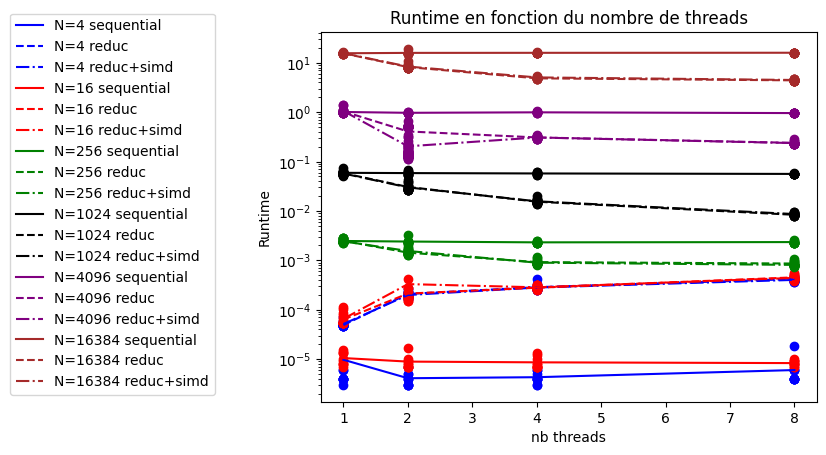

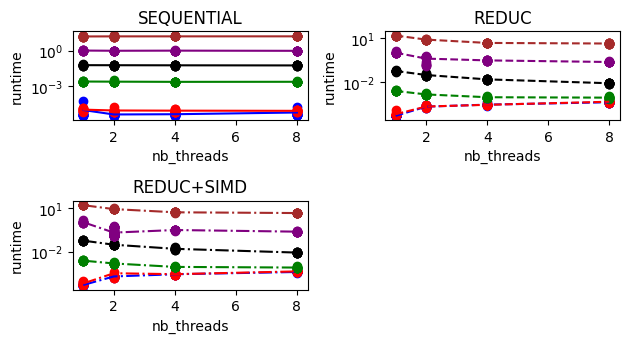

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('stats_part2.csv',header=0,names=['name','nb_threads','N','M','nrepeats','runtime'],dtype={
                     'name' : str,
                     'nb_threads':int,
                     'N': int,
                     'M': int,
                     'nrepeats' : int,
                     'runtime' : float
                 })

color_n_m = {2**2 : "blue", 2**4 : "red", 2**8 : "green", 2**10 : "black", 2**12 : "purple", 2**14 :"brown", 2**16:"pink"}

for N in df['N'].drop_duplicates():
    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_1 sequential"]
    mean_stats = df_plot.groupby(['N','name','nb_threads']).mean().reset_index()
    plt.plot(mean_stats['nb_threads'], mean_stats['runtime'],linestyle="solid", label=f'N={N} sequential', color=color_n_m[N])
    plt.scatter(df_plot['nb_threads'], df_plot['runtime'], label=None, color = color_n_m[N])

    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_2 reduction"]
    mean_stats = df_plot.groupby(['N','name','nb_threads']).mean().reset_index()
    plt.plot(mean_stats['nb_threads'], mean_stats['runtime'],linestyle="dashed", label=f'N={N} reduc', color = color_n_m[N])
    plt.scatter(df_plot['nb_threads'], df_plot['runtime'], label=None, color = color_n_m[N])

    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_3 reduction+simd"]
    mean_stats = df_plot.groupby(['N','name','nb_threads']).mean().reset_index()
    plt.plot(mean_stats['nb_threads'], mean_stats['runtime'],linestyle="dashdot", label=f'N={N} reduc+simd', color = color_n_m[N])
    plt.scatter(df_plot['nb_threads'], df_plot['runtime'], label=None, color = color_n_m[N])

plt.yscale('log')
plt.xlabel('nb threads')
plt.ylabel('Runtime')
plt.title("Runtime en fonction du nombre de threads")
plt.legend(loc='lower right', bbox_to_anchor=(-0.2, 0))

fig = plt.figure()
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)

for N in df['N'].drop_duplicates():
    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_1 sequential"]
    mean_stats = df_plot.groupby(['N','name','nb_threads']).mean().reset_index()
    ax1.plot(mean_stats['nb_threads'], mean_stats['runtime'],linestyle="solid", label=f'{N} sequential', color=color_n_m[N])
    ax1.set_yscale('log')
    ax1.scatter(df_plot['nb_threads'], df_plot['runtime'], label=None, color = color_n_m[N])
    ax1.set_title("SEQUENTIAL")
    ax1.set_xlabel("nb_threads")
    ax1.set_ylabel("runtime")

for N in df['N'].drop_duplicates():
    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_2 reduction"]
    mean_stats = df_plot.groupby(['N','name','nb_threads']).mean().reset_index()
    ax2.plot(mean_stats['nb_threads'], mean_stats['runtime'],linestyle="dashed", label=f'{N} reduc', color = color_n_m[N])
    ax2.set_yscale('log')
    ax2.scatter(df_plot['nb_threads'], df_plot['runtime'], label=None, color = color_n_m[N])
    ax2.set_title("REDUC")
    ax2.set_xlabel("nb_threads")
    ax2.set_ylabel("runtime")

for N in df['N'].drop_duplicates():
    df_plot = df[(df['N'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_3 reduction+simd"]
    mean_stats = df_plot.groupby(['N','name','nb_threads']).mean().reset_index()
    ax3.plot(mean_stats['nb_threads'], mean_stats['runtime'],linestyle="dashdot", label=f'{N} reduc+simd', color = color_n_m[N])
    ax3.set_yscale('log')
    ax3.scatter(df_plot['nb_threads'], df_plot['runtime'], label=None, color = color_n_m[N])
    ax3.set_title("REDUC+SIMD")
    ax3.set_xlabel("nb_threads")
    ax3.set_ylabel("runtime")


plt.tight_layout()
plt.show()

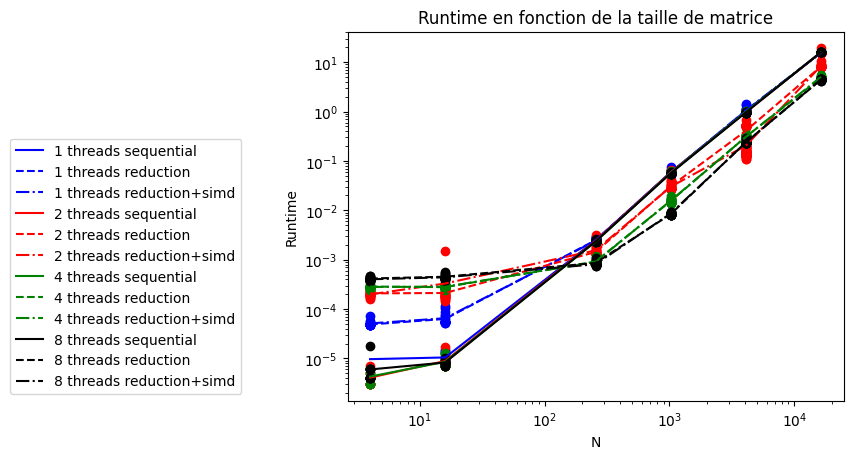

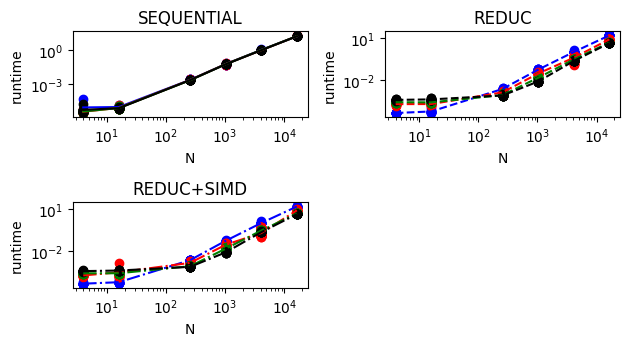

In [52]:
color_thread = {1 : "blue",2 : "red", 4 : "green", 8: "black"}

for N in df['nb_threads'].drop_duplicates():
    df_plot = df[(df['nb_threads'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_1 sequential"]
    mean_stats = df_plot.groupby(['nb_threads','name','N']).mean().reset_index()
    plt.plot(mean_stats['N'], mean_stats['runtime'],linestyle="solid", label=f'{N} threads sequential', color=color_thread[N])
    plt.scatter(df_plot['N'], df_plot['runtime'], label=None, color = color_thread[N])

    df_plot = df[(df['nb_threads'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_2 reduction"]    
    mean_stats = df_plot.groupby(['nb_threads','name','N']).mean().reset_index()
    plt.plot(mean_stats['N'], mean_stats['runtime'],linestyle="dashed", label=f'{N} threads reduction', color=color_thread[N])
    plt.scatter(df_plot['N'], df_plot['runtime'], label=None, color = color_thread[N])

    df_plot = df[(df['nb_threads'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_3 reduction+simd"]
    mean_stats = df_plot.groupby(['nb_threads','name','N']).mean().reset_index()
    plt.plot(mean_stats['N'], mean_stats['runtime'],linestyle="dashdot", label=f'{N} threads reduction+simd', color=color_thread[N])
    plt.scatter(df_plot['N'], df_plot['runtime'], label=None, color = color_thread[N])

plt.yscale('log')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Runtime')
plt.title('Runtime en fonction de la taille de matrice')
plt.legend(loc='lower right', bbox_to_anchor=(-0.2, 0))

fig = plt.figure()
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)

for N in df['nb_threads'].drop_duplicates():
    df_plot = df[(df['nb_threads'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_1 sequential"]
    mean_stats = df_plot.groupby(['nb_threads','name','N']).mean().reset_index()
    ax1.plot(mean_stats['N'], mean_stats['runtime'],linestyle="solid", label=f'{N} threads sequential', color=color_thread[N])
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.scatter(df_plot['N'], df_plot['runtime'], label=None, color = color_thread[N])
    ax1.set_title("SEQUENTIAL")
    ax1.set_xlabel("N")
    ax1.set_ylabel("runtime")

for N in df['nb_threads'].drop_duplicates():
    df_plot = df[(df['nb_threads'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_2 reduction"]    
    mean_stats = df_plot.groupby(['nb_threads','name','N']).mean().reset_index()
    ax2.plot(mean_stats['N'], mean_stats['runtime'],linestyle="dashed", label=f'{N} threads reduction', color=color_thread[N])
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.scatter(df_plot['N'], df_plot['runtime'], label=None, color = color_thread[N])
    ax2.set_title("REDUC")
    ax2.set_xlabel("N")
    ax2.set_ylabel("runtime")

for N in df['nb_threads'].drop_duplicates():
    df_plot = df[(df['nb_threads'] == int(N))]
    df_plot = df_plot[df_plot['name'] == "2_3 reduction+simd"]
    mean_stats = df_plot.groupby(['nb_threads','name','N']).mean().reset_index()
    ax3.plot(mean_stats['N'], mean_stats['runtime'],linestyle="dashdot", label=f'{N} threads reduction+simd', color=color_thread[N])
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.scatter(df_plot['N'], df_plot['runtime'], label=None, color = color_thread[N])
    ax3.set_title("REDUC+SIMD")
    ax3.set_xlabel("N")
    ax3.set_ylabel("runtime")

plt.tight_layout()
plt.show()


### Discussion

#### Sequential
De même que lors de la première partie, nous pouvons observer que le code séquentiel n'est impacté que par la taille de la matrice et non par le nombre de threads. Nous pouvons également noter que cette implémentation est plus rapide que celle parallélisée jusqu'à une certaine taille de matrice, facilement visible sur le 2ème graphique global.

#### Reduction
Après l'implémentation de la réduction, nous observons un gain de performance à l'exécution, qui arrive assez rapidement sur un plateau lorsque le nombre de thread augmente. Lorsque la taille de la matrice est trop petite, la réduction a des performances moins intérressantes que la séquentielle puisque nous divisons trop les calculs par rapport au nombre total réalisable.

#### Reduction et SIMD
L'ajout du pragma SIMD à notre code n'a pas modifié les performances de notre programme car ce dernier a été compilé avec des options d'optimisation permettant de vectoriser automatiquement les boucles. Les 2 courbes sont donc superposées.

#### Conlusion
Finalement, de même que dans la partie 1 nous avons constater que la parallélisation du code n'avait de sens que lorsque l'on avait de gros volumes de données car autrement le code séquentiel est nettement suffisant. Dans le cadre du TP, nous n'avons pas pu voir de différence notable de performance avec l'ajout du SIMD mais l'implémentation de la réduction représente déjà un bon gain eu niveau du temps d'exécution à partir d'une certaine taille de matrice (N=2^8). Ce dernier sera d'autant meilleur que nous augmentons les threads, néanmoins l'asymptote du minimum de temps d'exécution semble rapidement atteinte.